# Simulation noise
Nguyen Viet Hoang <br>
Các noise model tác động lên chất lượng ảnh


In [39]:
from importlib.resources import path
from pathlib import Path 
import cv2
import numpy as np
import abc
from numpy.random import Generator
import matplotlib.pyplot as plt

class Noise(metaclass = abc.ABCMeta):
    def __init__(self, filepath: Path):
        self.filepath = filepath
        
    def get_matrix_image(self):
        return cv2.imread(str(self.filepath), cv2.IMREAD_GRAYSCALE)
    
    @abc.abstractmethod
    def noise(self)->np.array:
        pass
    
    def add_noise(self) ->np.array:
        noise_gen = self.noise().astype('uint8')
        origin_image = self.get_matrix_image()
        noisy_image = cv2.add(origin_image,noise_gen)
        cv2.normalize(noisy_image, noisy_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)
        return noisy_image
       
class GaussianNoise(Noise):
    def __init__(self, filepath, mean = 0, var = 0.1):
        super().__init__(filepath=filepath)
        self.mean = mean
        self.var = var
    
    def noise(self)->np.array:
        image = self.get_matrix_image()
        row, col = image.shape
        sigma = self.var**0.5
        gauss = np.random.normal(self.mean,sigma,image.size)
        gauss = gauss.reshape(row, col).astype('uint8')
        return gauss
  
class RayleighNoise(Noise):
    def __init__(self, filepath, scale):
        super().__init__(filepath=filepath)
        self.scale = scale
        
    def noise(self)->np.array:
        image = self.get_matrix_image()
        row, col, ch = image.shape
        rayleigh = np.random.rayleigh(self.scale, (row, col, ch))
        return rayleigh
    
class ExponentialNoise(Noise):
    def __init__(self, filepath, scale):
        super().__init__(filepath = filepath)
        self.scale = scale
        
    def noise(self)->np.array:
        image = self.get_matrix_image()    
        exponent = np.random.default_rng().exponential(self.scale, image.shape)
        return exponent
    
class SaltAndPeperNoise(Noise):
    def __init__(self,
                 filepath: Path,
                 Ps = 0.5,
                 P = 0.004):
        super().__init__(filepath)
        self.Ps = Ps
        self.P = P
    
    def noise(self)->np.array:
        image = self.get_matrix_image()
    
        out = np.copy(image)
        
        # Salt mode
        num_salt = np.ceil(self.P * image.size * self.Ps)
        coords = [np.random.randint(0, i - 1, int(num_salt))
                for i in image.shape]
        
        # print(np.asarray(coords).shape)
        
        out[tuple(coords)] = 1
        
        
        # Pepper mode
        num_pepper = np.ceil(self.P* image.size * (self.P - self.Ps))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
                for i in image.shape]
        
        out[tuple(coords)] = 0
        return np.asarray(out)
     
class UniformNoise(Noise):
    def __init__(self,
                 filepath:Path,
                 a = 0.0, 
                 b = 2.0):
        super().__init__(filepath=filepath)
        self.a = a
        self.b = b
        
    def noise(self)->np.array:
        image = self.get_matrix_image()
        uniform_gen = np.random.default_rng().uniform(self.a, self.b, image.shape)
        print(uniform_gen)
        return np.asarray(uniform_gen)
    


In [8]:
import cv2
from config import Flag
import matplotlib.pyplot as plt
from scipy.fftpack import fftn, ifftn, fftshift
def metric(gt, ri):
    SE = (gt - ri)**2
    MSE = SE.mean()
    RMSE = MSE**0.5
    PSNR = 10*np.log10(255*255/MSE)
    return {"MSE": MSE,"RMSE": RMSE,"PSNR":PSNR}

In [13]:
prefix = Flag.image_origin
file_name = prefix / 'pattern2.png'
shape_img = (480, 480)
image = cv2.imread(str(file_name), cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, shape_img)

## Gaussian noise

{'MSE': 93.41519097222222, 'RMSE': 9.665153437593332, 'PSNR': 28.426628548845187}


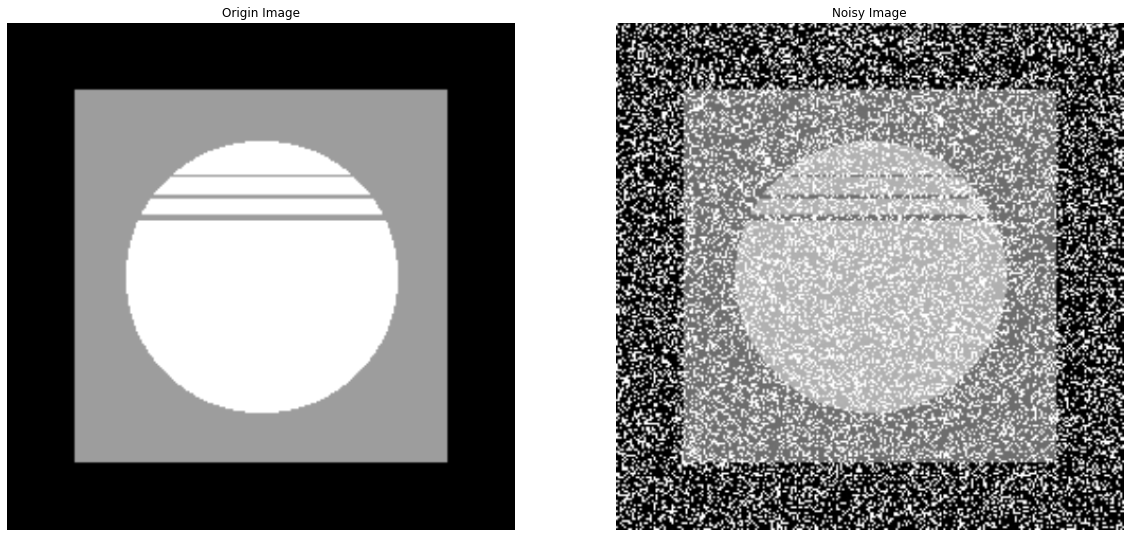

In [14]:
gauss_noise = GaussianNoise(str(file_name), mean = 0, var = 3.5)
image_gauss_noise = gauss_noise.add_noise()
image_gauss_noise = cv2.resize(image_gauss_noise, shape_img)
# print(image_gauss_noise.shape)
eval_img = metric(image, image_gauss_noise)
print(eval_img)

plt.figure(figsize=(20, 12))
plt.subplot(121)
plt.title("Origin Image")
plt.axis('off')
plt.imshow(image, cmap='gray')
plt.subplot(122)
plt.title("Noisy Image")
plt.axis('off')
plt.imshow(image_gauss_noise, cmap='gray')

## Sault and Pepper Noise

{'MSE': 0.7716927083333334, 'RMSE': 0.8784604193322163, 'PSNR': 49.256359642146364}


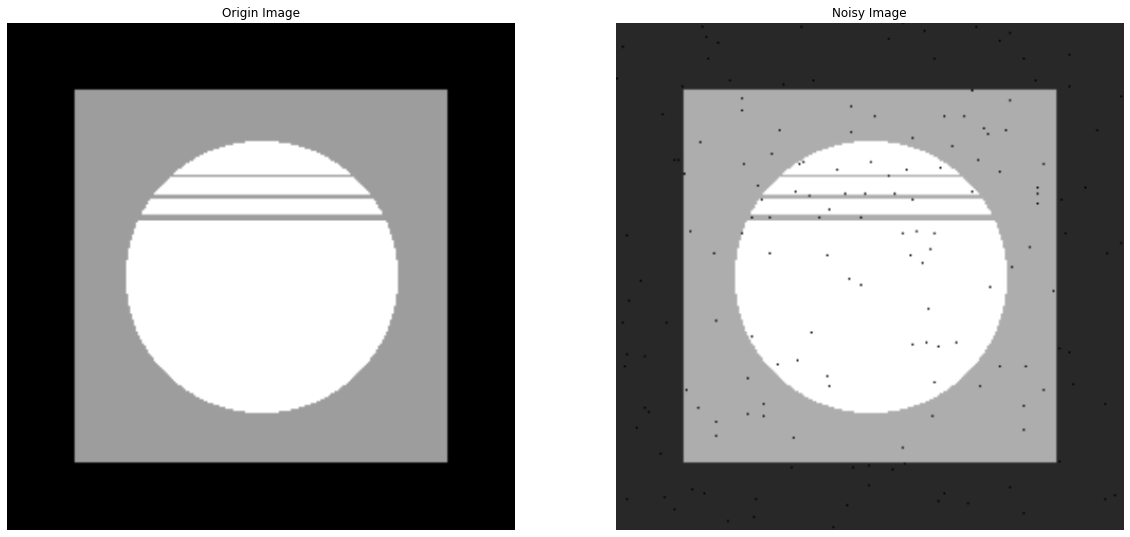

In [15]:
# from add_noise import SaltAndPeperNoise
# file_name = prefix / 'pattern2.png'
# image = cv2.imread(str(file_name), cv2.IMREAD_GRAYSCALE)
saltAndPeperNoise = SaltAndPeperNoise(str(file_name), Ps=0.04, P=0.05)
image_snp_noise = saltAndPeperNoise.noise()
image_snp_noise = cv2.resize(image_snp_noise, shape_img)
metric_snp = metric(image, image_snp_noise)
print(metric_snp)

plt.figure(figsize=(20, 12))
plt.subplot(121)
plt.title("Origin Image")
plt.axis('off')
plt.imshow(image, cmap='gray')
plt.subplot(122)
plt.title("Noisy Image")
plt.axis('off')
plt.imshow(image_snp_noise, cmap='gray')

## Erlang Noise

## Exponential Noise

{'MSE': 105.881953125, 'RMSE': 10.289895680958091, 'PSNR': 27.882584170600335}


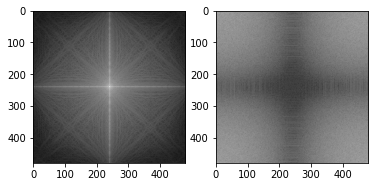

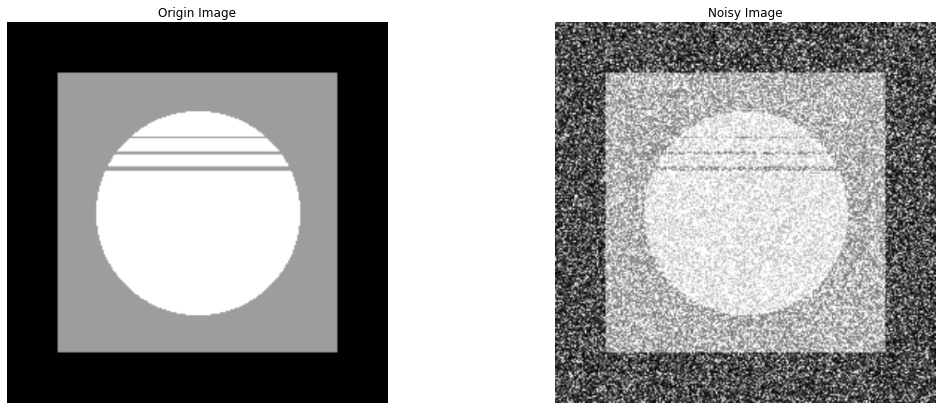

In [42]:
ex_noise = ExponentialNoise(filepath=file_name, scale=89)
image_ex_noise = ex_noise.add_noise()
image_ex_noise = cv2.resize(image_ex_noise, shape_img)

F_o = fftn(image)
Fn_uni = fftn(image_ex_noise)

plt.subplot(121)
plt.imshow(fftshift(np.log(np.abs(F_o)+1)), cmap="gray")
plt.subplot(122)
plt.imshow(np.log(np.abs(Fn_uni)+1), cmap="gray")

metric_snp = metric(image, image_ex_noise)
print(metric_snp)

plt.figure(figsize=(18, 7))
plt.subplot(121)
plt.title("Origin Image")
plt.axis('off')
plt.imshow(image, cmap='gray')
plt.subplot(122)
plt.title("Noisy Image")
plt.axis('off')
plt.imshow(image_ex_noise, cmap='gray')

## Uniform Noise

[[0.13546934 0.61896022 0.19847322 ... 0.71990873 0.28401754 0.68614476]
 [0.68272686 0.02068815 0.90806092 ... 0.88230325 0.46123746 0.33703899]
 [0.87569783 0.16790567 0.53809681 ... 0.56466332 0.51434392 0.44014048]
 ...
 [0.51428547 0.83564325 0.49373528 ... 0.5640138  0.72265639 0.72641384]
 [0.1952313  0.77093375 0.90822599 ... 0.68896887 0.89459322 0.49126513]
 [0.60213014 0.610553   0.27673899 ... 0.48407718 0.73031604 0.29159231]]
{'MSE': 75.07891927083334, 'RMSE': 8.664809246073068, 'PSNR': 29.37562348358287}


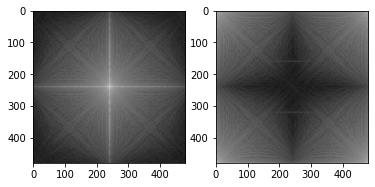

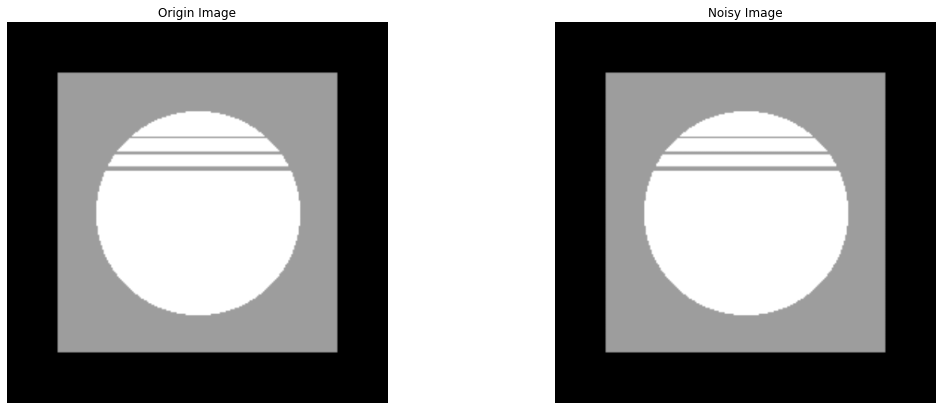

In [37]:
uni_noise = UniformNoise(filepath=file_name, a=0, b=1)
image_uni_noise = uni_noise.add_noise()
image_uni_noise = cv2.resize(image_uni_noise, shape_img)

F_o = fftn(image)
Fn_uni = fftn(image_uni_noise)

plt.subplot(121)
plt.imshow(fftshift(np.log(np.abs(F_o)+1)), cmap="gray")
plt.subplot(122)
plt.imshow(np.log(np.abs(Fn_uni)+1), cmap="gray")

metric_snp = metric(image, image_uni_noise)
print(metric_snp)

plt.figure(figsize=(18, 7))
plt.subplot(121)
plt.title("Origin Image")
plt.axis('off')
plt.imshow(image, cmap='gray')
plt.subplot(122)
plt.title("Noisy Image")
plt.axis('off')
plt.imshow(image_uni_noise, cmap='gray')

